In [613]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [614]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"
# enrichment_file = "enrichr"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Actually, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

elif enrichment_file == "enrichr": # Get enrichr results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichr.csv", index_col=0)
    enr.rename(columns={"path_name": "native", "adj_p_val": "p_value"}, inplace=True)

enr["name"] = enr["native"]

In [615]:
# enr = enr[enr["source"] == "GO_Molecular_Function_2021"] # Molecular function
# enr = enr[enr["source"] == "GO_Cellular_Component_2021"] # Cellular component
# enr = enr[enr["source"] == "GO_Biological_Process_2021"] # Biological process
# enr = enr[enr["source"] == "KEGG_2021_Human"] # KEGG pathways
# enr = enr[enr["source"] == "Reactome_2016"] # Reactome pathways
enr = enr[enr["source"] == "PanglaoDB_Augmented_2021"] # Cell types

In [616]:
celltypes = [
    "Monocytes",
    "B Cells",
    "T Helper Cells",
    "T Cytotoxic Cells",
    "NK Cells",
    "Erythroid-like And Erythroid Precursor Cells",
]
idx = enr["native"].map(lambda x: x in celltypes)
idx |= (enr["source"] != "PanglaoDB_Augmented_2021")
enr = enr[idx]


In [617]:
enr = enr[enr["p_value"] < .05]

In [618]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [619]:
enr

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
2,PanglaoDB_Augmented_2021,Monocytes,Monocytes,2.555249e-13,True,NaN,176,107,23,6654,0.214953,0.130682,bottom_mofa 2,[],mofa,2,12.592567
11,PanglaoDB_Augmented_2021,B Cells,B Cells,1.150919e-10,True,NaN,182,88,19,6654,0.215909,0.104396,bottom_mofa 1,[],mofa,1,9.938955
36,PanglaoDB_Augmented_2021,T Helper Cells,T Helper Cells,3.271700e-05,True,NaN,148,85,12,6654,0.141176,0.081081,bottom_mofa 4,[],mofa,4,4.485227
40,PanglaoDB_Augmented_2021,NK Cells,NK Cells,4.056617e-05,True,NaN,157,83,12,6654,0.144578,0.076433,bottom_mofa 0,[],mofa,0,4.391836
43,PanglaoDB_Augmented_2021,NK Cells,NK Cells,6.221044e-05,True,NaN,157,85,12,6654,0.141176,0.076433,bottom_mofa 4,[],mofa,4,4.206137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,PanglaoDB_Augmented_2021,NK Cells,NK Cells,3.028758e-02,True,NaN,157,93,9,6654,0.096774,0.057325,mowgli 18,[],mowgli,18,1.518735
1228,PanglaoDB_Augmented_2021,NK Cells,NK Cells,3.092521e-02,True,NaN,157,93,9,6654,0.096774,0.057325,mowgli 6,[],mowgli,6,1.509687
1397,PanglaoDB_Augmented_2021,B Cells,B Cells,4.298802e-02,True,NaN,182,85,9,6654,0.105882,0.049451,mowgli 0,[],mowgli,0,1.366653
1431,PanglaoDB_Augmented_2021,T Helper Cells,T Helper Cells,4.608823e-02,True,NaN,148,84,8,6654,0.095238,0.054054,mowgli 28,[],mowgli,28,1.336410


## Is Mowgli more specific?

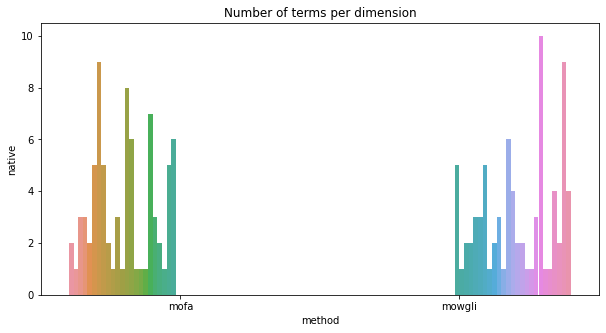

In [446]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(
    data=enr.groupby(["method", "query"])["native"].nunique().reset_index(),
    x="method",
    y="native",
    hue="query",
    ax=ax,
)
ax.set_title("Number of terms per dimension")
ax.get_legend().remove()
plt.show()
# + and - counted separately or mofa

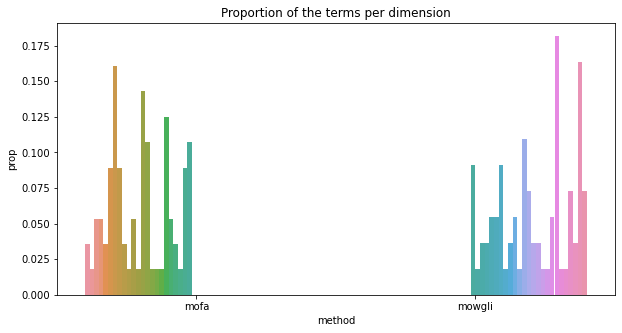

In [447]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df = enr.groupby(["method", "query"])["native"].nunique().reset_index()
df["nterms"] = df["method"].map(enr.groupby("method")["native"].nunique())
df["prop"] = df["native"] / df["nterms"]
sns.barplot(
    data=df,
    x="method",
    y="prop",
    hue="query",
    ax=ax,
)
ax.set_title("Proportion of the terms per dimension")
ax.get_legend().remove()
plt.show()
# + and - counted separately or mofa

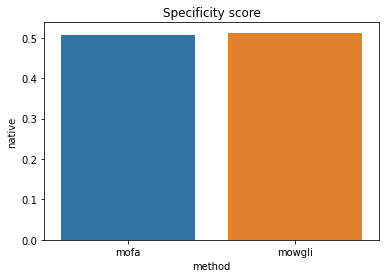

In [448]:
# specificity score
s = enr.groupby("method")["native"].nunique() # nterms
s += enr.groupby("method")["query"].nunique() # ndims
s /= 2*enr.groupby("method")["native"].count() # 2*nlinks
plt.title("Specificity score")
sns.barplot(data=pd.DataFrame(s).reset_index(), x="method", y="native")
plt.show()

## Does Mowgli find other things?

In [449]:
mofa_terms = enr.loc[enr["method"] == "mofa", "native"].unique()
mowgli_terms = enr.loc[enr["method"] == "mowgli", "native"].unique()
intersecting_terms = np.intersect1d(mofa_terms, mowgli_terms)
terms_in_mofa_only = np.setdiff1d(mofa_terms, mowgli_terms)
terms_in_mowgli_only = np.setdiff1d(mowgli_terms, mofa_terms)

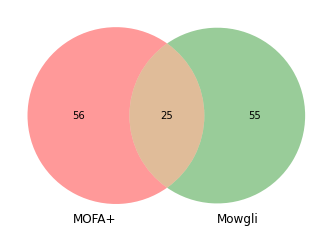

In [450]:
venn2(subsets = (len(mofa_terms), len(mowgli_terms), len(intersecting_terms)), set_labels = ('MOFA+', 'Mowgli'))
plt.show()

<AxesSubplot:xlabel='term_size'>

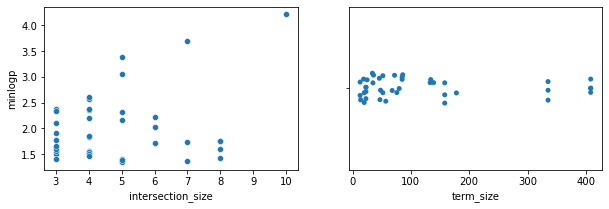

In [455]:
df = enr.set_index("native").loc[
    terms_in_mofa_only,
    ["minlogp", "term_size", "query_size", "intersection_size"],
].reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(data=df, x="intersection_size", y="minlogp", ax=axes[0])
sns.stripplot(data=df, x="term_size", ax=axes[1])

<AxesSubplot:xlabel='term_size'>

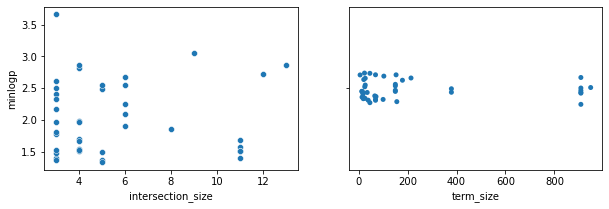

In [456]:
df = enr.set_index("native").loc[
    terms_in_mowgli_only,
    ["minlogp", "term_size", "query_size", "intersection_size"],
].reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.scatterplot(data=df, x="intersection_size", y="minlogp", ax=axes[0])
sns.stripplot(data=df, x="term_size", ax=axes[1])

In [461]:
enr.set_index("native").loc[terms_in_mofa_only].sort_values("intersection_size", ascending=False).head()

,source,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
native,,,,,,,,,,,,,,,,
positive regulation of cytokine production (GO:0001819),GO_Biological_Process_2021,positive regulation of cytokine production (GO...,0.000061,True,NaN,335,46,10,14937,0.217391,0.029851,bottom_mofa 3,[],mofa,3,4.216814
regulation of cell migration (GO:0030334),GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.025682,True,NaN,408,45,8,14937,0.177778,0.019608,top_mofa 13,[],mofa,13,1.590378
regulation of cell migration (GO:0030334),GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.017405,True,NaN,408,42,8,14937,0.190476,0.019608,bottom_mofa 12,[],mofa,12,1.759322
regulation of cell migration (GO:0030334),GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.037622,True,NaN,408,48,8,14937,0.166667,0.019608,bottom_mofa 4,[],mofa,4,1.424558
regulation of cell migration (GO:0030334),GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.017704,True,NaN,408,43,8,14937,0.186047,0.019608,top_mofa 7,[],mofa,7,1.751920


In [460]:
enr.set_index("native").loc[terms_in_mowgli_only].sort_values("intersection_size", ascending=False).head()

,source,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
native,,,,,,,,,,,,,,,,
positive regulation of transcription by RNA polymerase II (GO:0045944),GO_Biological_Process_2021,positive regulation of transcription by RNA po...,0.001388,True,NaN,908,44,13,14937,0.295455,0.014317,mowgli 3,[],mowgli,3,2.857505
positive regulation of transcription by RNA polymerase II (GO:0045944),GO_Biological_Process_2021,positive regulation of transcription by RNA po...,0.001873,True,NaN,908,39,12,14937,0.307692,0.013216,mowgli 1,[],mowgli,1,2.727490
positive regulation of transcription by RNA polymerase II (GO:0045944),GO_Biological_Process_2021,positive regulation of transcription by RNA po...,0.030686,True,NaN,908,42,11,14937,0.261905,0.012115,mowgli 13,[],mowgli,13,1.513055
"negative regulation of transcription, DNA-templated (GO:0045892)",GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",0.039500,True,NaN,948,42,11,14937,0.261905,0.011603,mowgli 5,[],mowgli,5,1.403402
positive regulation of transcription by RNA polymerase II (GO:0045944),GO_Biological_Process_2021,positive regulation of transcription by RNA po...,0.031454,True,NaN,908,42,11,14937,0.261905,0.012115,mowgli 37,[],mowgli,37,1.502320


## Does Mowgli respect biology better?

In [620]:
import muon as mu
import anndata as ad
import mofax
import scanpy as sc

# Define the data folders.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
fig_folder = (
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/visualize/figures/"
)
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"


# Load the data.
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

# Load the MOFA model.
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()

# Load the Mowgli model.
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]

# This is needed somehow.
mdata.uns = {}

# Make an object for the Mowgli embedding.
mowgli_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
mowgli_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Make an object for the MOFA embedding.
mofa_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
mofa_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

In [621]:
# Compute neighbors for Mowgli and MOFA.
sc.pp.neighbors(mowgli_embedding, n_neighbors=25)
sc.pp.neighbors(mofa_embedding, n_neighbors=25)

# Compute Leiden for Mowgli and MOFA.
# The extra level of high resolution is useful to clean up the heatmap.
sc.tl.leiden(mowgli_embedding, resolution=0.2, key_added="leiden")
sc.tl.leiden(mofa_embedding, resolution=0.2, key_added="leiden")

# Annotate the MOFA emebdding.
cluster_names = {
    1: "B cells",
    8: "B cells",
    0: "CD4 T cells",
    2: "CD4 T cells",
    4: "CD8 T cells",
    6: "CD8 T cells",
    3: "Monocytes",
    5: "NK cells",
    7: "MAIT T cells",
    9: "Erythroid cells",
}
mofa_embedding.obs["leiden"] = [
    cluster_names[c] for c in mofa_embedding.obs["leiden"].cat.codes
]

# Annotate the Mowgli embedding.
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
mowgli_embedding.obs["leiden"] = [
    cluster_names[c] for c in mowgli_embedding.obs["leiden"].cat.codes
]

In [622]:
mowgli_embedding.obs["leiden"] = pd.Categorical(mowgli_embedding.obs["leiden"])
mofa_embedding.obs["leiden"] = pd.Categorical(mofa_embedding.obs["leiden"])

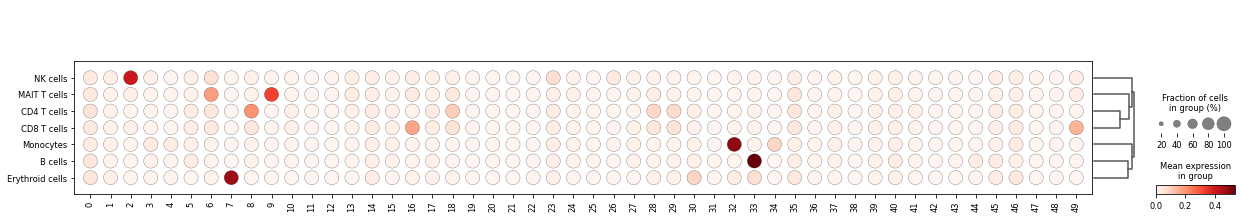

In [623]:
sc.tl.dendrogram(mowgli_embedding, groupby="leiden")
sc.pl.dotplot(mowgli_embedding, mowgli_embedding.var_names, groupby="leiden", dendrogram=True, expression_cutoff=-100)

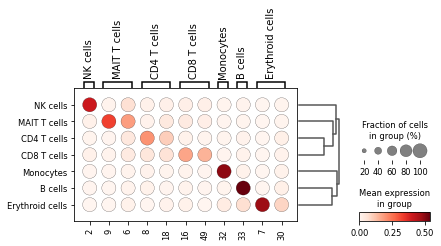

In [624]:
sc.tl.dendrogram(mowgli_embedding, groupby="leiden")
markers = {
    "MAIT T cells": ["9", "6"],
    "NK cells": ["2"],
    "CD4 T cells": ["8", "18"],
    "CD8 T cells": ["16", "49"],
    "Monocytes": ["32"],
    "B cells": ["33"],
    "Erythroid cells": ["7", "30"],
}
sc.pl.dotplot(mowgli_embedding, markers, groupby="leiden", dendrogram=True, expression_cutoff=-100)

In [639]:
mowgli_pvals = ad.AnnData(1e-3 + np.zeros((len(celltypes), mowgli_embedding.n_vars)))
mowgli_pvals.obs_names = celltypes
mowgli_pvals.var_names = mowgli_embedding.var_names
for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["method"] == "mowgli"
    mowgli_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mowgli_pvals.obs["celltype"] = pd.Categorical(mowgli_pvals.obs_names)

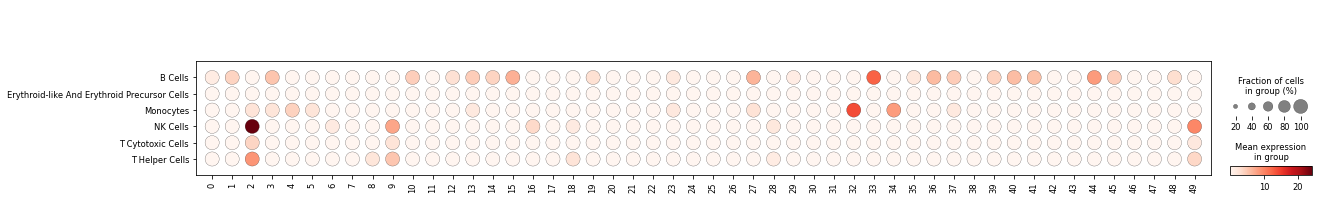

In [640]:
sc.pl.dotplot(mowgli_pvals, mowgli_pvals.var_names, groupby="celltype", expression_cutoff=0)

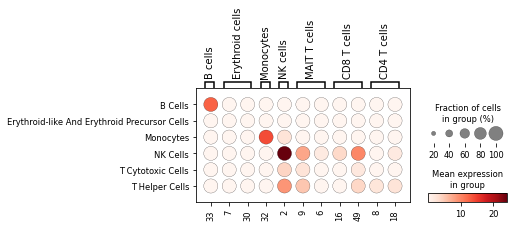

In [642]:
markers = {
    "B cells": ["33"],
    "Erythroid cells": ["7", "30"],
    "Monocytes": ["32"],
    "NK cells": ["2"],
    "MAIT T cells": ["9", "6"],
    "CD8 T cells": ["16", "49"],
    "CD4 T cells": ["8", "18"],
}
sc.pl.dotplot(mowgli_pvals, markers, groupby="celltype")

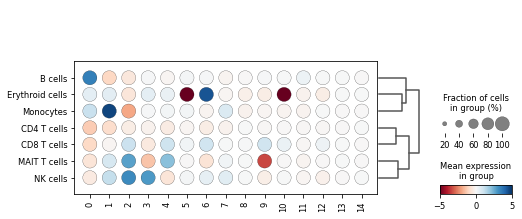

In [629]:
sc.tl.dendrogram(mofa_embedding, groupby="leiden")
sc.pl.dotplot(mofa_embedding, mofa_embedding.var_names, groupby="leiden", dendrogram=True, cmap="RdBu", vmin=-5, vmax=5, expression_cutoff=-100)

categories: B cells, CD4 T cells, CD8 T cells, etc.
var_group_labels: B cells, Erythroid cells, Monocytes, etc.


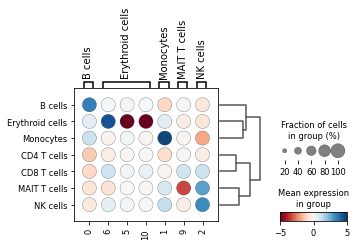

In [630]:
sc.tl.dendrogram(mofa_embedding, groupby="leiden")
markers = {
    "B cells": ["0"],
    "Erythroid cells": ["6", "5", "10"],
    "Monocytes": ["1"],
    "MAIT T cells": ["9"],
    "NK cells": ["2"],
}
sc.pl.dotplot(mofa_embedding, markers, groupby="leiden", dendrogram=True, cmap="RdBu", vmin=-5, vmax=5, expression_cutoff=-100, )

In [636]:
mofa_pvals = ad.AnnData(1e-3 + np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_pvals.obs_names = celltypes
mofa_pvals.var_names = mofa_embedding.var_names
for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["method"] == "mofa"
    mofa_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mofa_pvals.obs["celltype"] = pd.Categorical(mofa_pvals.obs_names)

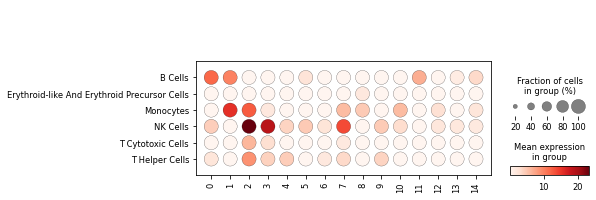

In [637]:
sc.pl.dotplot(mofa_pvals, mofa_pvals.var_names, groupby="celltype", expression_cutoff=0)

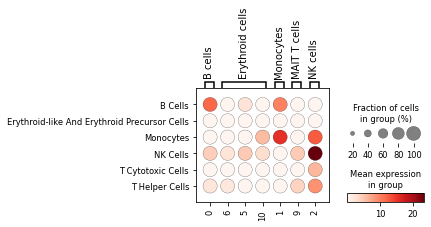

In [638]:
markers = {
    "B cells": ["0"],
    "Erythroid cells": ["6", "5", "10"],
    "Monocytes": ["1"],
    "MAIT T cells": ["9"],
    "NK cells": ["2"],
}
sc.pl.dotplot(mofa_pvals, markers, groupby="celltype")

## Count enrichments

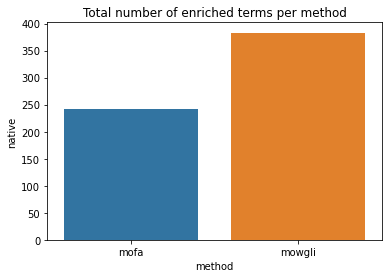

In [321]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

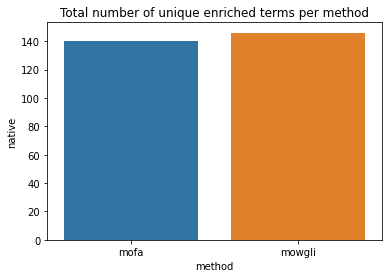

In [322]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

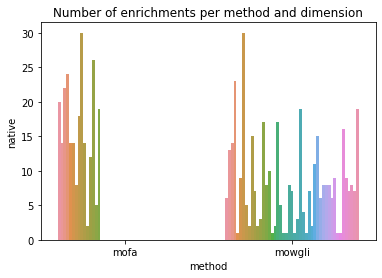

In [323]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

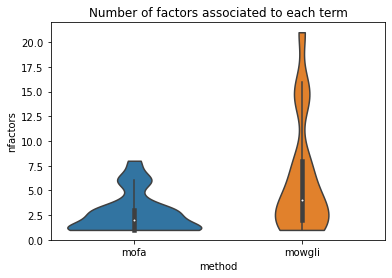

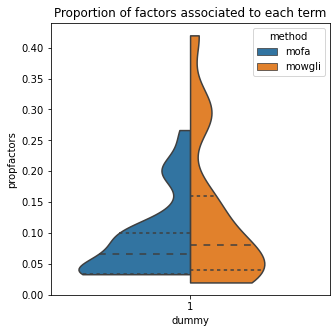

In [324]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [325]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.3512
Selectivity of Mowgli: 0.2559


## Biology-driven check

In [326]:
idx_mowgli = (enr["method"] == "mofa")
idx_mowgli = (enr["query"].str.startswith("top"))
idx_mowgli &= (enr["dim"] == 6)
enr[idx_mowgli].sort_values("p_value").head(10)

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
134,negative regulation of epithelial cell prolife...,mofa,GO_Biological_Process_2021,negative regulation of epithelial cell prolife...,0.000722,True,NaN,72,64,6,...,0.093750,0.083333,top_mofa 6,[],6,3.141317,3,30,0.100000,1
179,negative regulation of cell population prolife...,mofa,GO_Biological_Process_2021,negative regulation of cell population prolife...,0.009115,True,NaN,379,68,10,...,0.147059,0.026385,top_mofa 6,[],6,2.040224,3,30,0.100000,1
185,T cell activation (GO:0042110),mofa,GO_Biological_Process_2021,T cell activation (GO:0042110),0.011761,True,NaN,92,47,5,...,0.106383,0.054348,top_mofa 6,[],6,1.929547,1,30,0.033333,1
219,regulation of cell migration (GO:0030334),mofa,GO_Biological_Process_2021,regulation of cell migration (GO:0030334),0.037003,True,NaN,408,74,10,...,0.135135,0.024510,top_mofa 6,[],6,1.431759,8,30,0.266667,1
227,negative regulation of response to external st...,mofa,GO_Biological_Process_2021,negative regulation of response to external st...,0.040924,True,NaN,118,78,6,...,0.076923,0.050847,top_mofa 6,[],6,1.388018,2,30,0.066667,1
237,regulation of GTPase activity (GO:0043087),mofa,GO_Biological_Process_2021,regulation of GTPase activity (GO:0043087),0.048407,True,NaN,189,74,7,...,0.094595,0.037037,top_mofa 6,[],6,1.315091,1,30,0.033333,1
241,regulation of immune response (GO:0050776),mofa,GO_Biological_Process_2021,regulation of immune response (GO:0050776),0.049744,True,NaN,179,17,4,...,0.235294,0.022346,top_mofa 6,[],6,1.303262,3,30,0.100000,1


In [327]:
idx_mofa = (enr["method"] == "mofa")
idx_mofa &= (enr["dim"] == 0)
idx_mowgli = (enr["method"] == "mowgli")
idx_mowgli &= (enr["dim"] == 33)
pd.concat((enr[idx_mofa].sort_values("p_value").head(10), enr[idx_mowgli].sort_values("p_value").head(10)))

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
115,regulation of B cell proliferation (GO:0030888),mofa,GO_Biological_Process_2021,regulation of B cell proliferation (GO:0030888),0.000018,True,NaN,46,56,6,...,0.107143,0.130435,top_mofa 0,[],0,4.738494,1,30,0.033333,1
116,antigen receptor-mediated signaling pathway (G...,mofa,GO_Biological_Process_2021,antigen receptor-mediated signaling pathway (G...,0.000019,True,NaN,185,72,10,...,0.138889,0.054054,top_mofa 0,[],0,4.719808,6,30,0.200000,1
119,B cell activation (GO:0042113),mofa,GO_Biological_Process_2021,B cell activation (GO:0042113),0.000206,True,NaN,85,74,7,...,0.094595,0.082353,top_mofa 0,[],0,3.685327,2,30,0.066667,1
136,interferon-gamma-mediated signaling pathway (G...,mofa,GO_Biological_Process_2021,interferon-gamma-mediated signaling pathway (G...,0.000770,True,NaN,68,70,6,...,0.085714,0.088235,top_mofa 0,[],0,3.113780,3,30,0.100000,1
140,regulation of B cell receptor signaling pathwa...,mofa,GO_Biological_Process_2021,regulation of B cell receptor signaling pathwa...,0.001544,True,NaN,23,56,4,...,0.071429,0.173913,top_mofa 0,[],0,2.811279,3,30,0.100000,1
22,"positive regulation of transcription, DNA-temp...",mofa,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",0.005153,True,NaN,1183,62,17,...,0.274194,0.014370,bottom_mofa 0,[],0,2.287957,6,30,0.200000,1
167,negative regulation of B cell activation (GO:0...,mofa,GO_Biological_Process_2021,negative regulation of B cell activation (GO:0...,0.006443,True,NaN,22,3,2,...,0.666667,0.090909,top_mofa 0,[],0,2.190925,3,30,0.100000,1
168,antigen processing and presentation of exogeno...,mofa,GO_Biological_Process_2021,antigen processing and presentation of exogeno...,0.006628,True,NaN,98,70,6,...,0.085714,0.061224,top_mofa 0,[],0,2.178618,1,30,0.033333,1
174,antigen processing and presentation of peptide...,mofa,GO_Biological_Process_2021,antigen processing and presentation of peptide...,0.007451,True,NaN,100,70,6,...,0.085714,0.060000,top_mofa 0,[],0,2.127784,1,30,0.033333,1
175,B cell receptor signaling pathway (GO:0050853),mofa,GO_Biological_Process_2021,B cell receptor signaling pathway (GO:0050853),0.007844,True,NaN,34,56,4,...,0.071429,0.117647,top_mofa 0,[],0,2.105482,1,30,0.033333,1


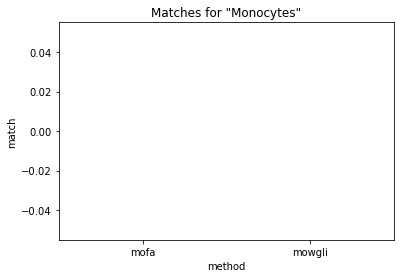

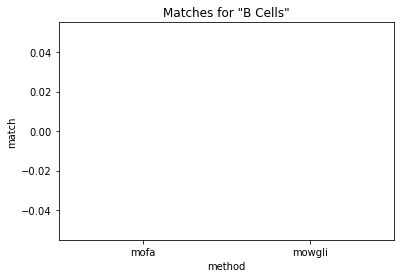

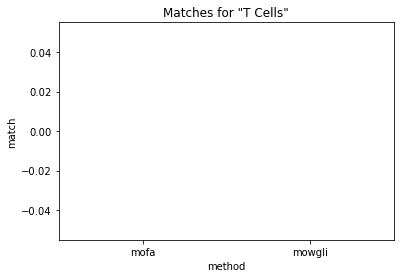

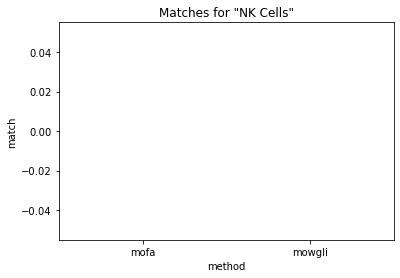

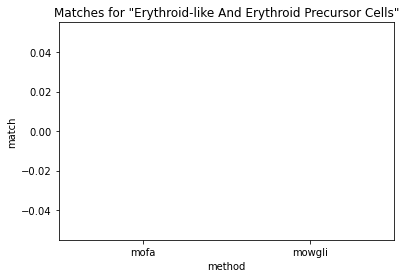

In [328]:
# TODO: check this, it seems weird
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()

for celltype in celltypes:
    try:
        barplot_matches(celltype)
    except:
        pass

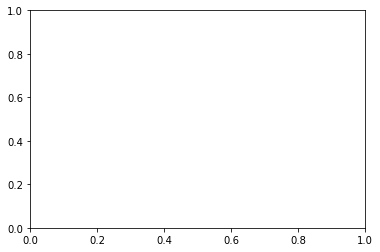

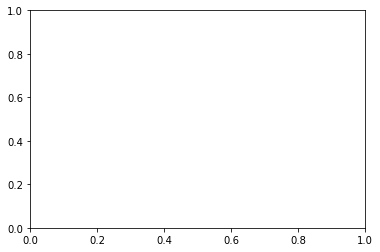

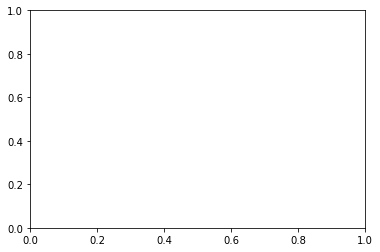

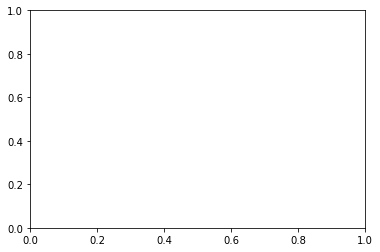

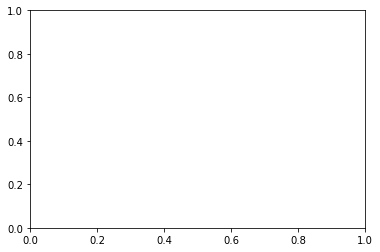

In [329]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

for celltype in celltypes:
    try:
        stripplot_matches(celltype)
    except:
        pass